# Performing PCA with an Undercomplete Linear Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder,decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)
autoencoder.compile(loss="mse",optimizer = optimizer)

In [2]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]

In [3]:
history = autoencoder.fit(X_train,X_train,epochs=500,verbose=False)
codings = autoencoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


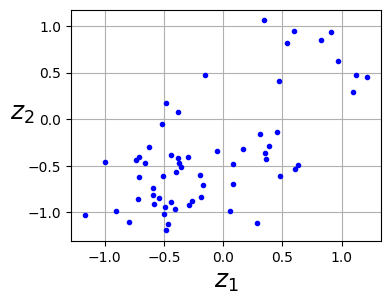

In [4]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# Stacked Autoencoders

In [5]:

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(20,activation="relu")
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28,28])
])

stacked_autoencoder = tf.keras.Sequential([stacked_encoder,stacked_decoder])
stacked_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())

history = stacked_autoencoder.fit(X_train,X_train,
                                  epochs = 30,
                                  validation_data=(X_valid,X_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0348 - val_loss: 0.0189
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0183 - val_loss: 0.0173
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0158 - val_loss: 0.0157
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0155 - val_loss: 0.0156
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0152 - val_loss: 0.0154
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0151 - val_loss: 0.0152
Epoch 9/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0150 - val_loss: 0.0154
Epoch 10/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 11/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 12/30
1719/1719 ━━━━━━━━

In [60]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index,:,:], cmap="binary")
        plt.axis("off")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


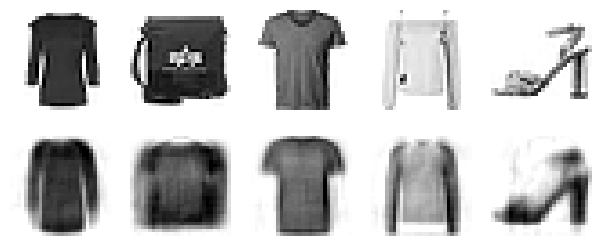

In [61]:

plot_reconstructions(stacked_autoencoder)
plt.show()

## Visualizing the Dataset

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne= TSNE(init="pca",learning_rate="auto")
X_valid_2D = tsne.fit_transform(X_valid_compressed)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(np.float64(-0.010662021301686767),
 np.float64(1.048126762919128),
 np.float64(-0.04987634718418121),
 np.float64(1.0474032908678055))

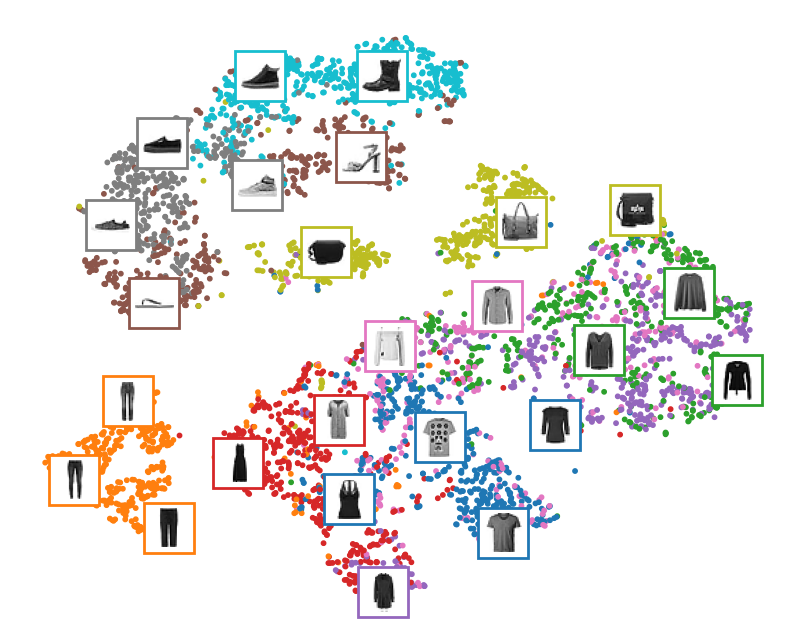

In [10]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

# Convolutional Autoencoders

In [11]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28,28,1]),
    tf.keras.layers.Conv2D(16,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(64,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(30,3,padding="same",activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D()
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3*3*16),
    tf.keras.layers.Reshape((3,3,16)),
    tf.keras.layers.Conv2DTranspose(32,3,strides=2,activation="relu"),
    tf.keras.layers.Conv2DTranspose(16,3,strides=2,padding="same",activation="relu"),
tf.keras.layers.Conv2DTranspose(1,3,strides=2,padding="same"),
    tf.keras.layers.Reshape([28,28])

])
conv_autoencoder = tf.keras.Sequential([conv_encoder,conv_decoder])
conv_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())
history = conv_autoencoder.fit(X_train,X_train,epochs=10,
                               validation_data=(X_valid,X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0465 - val_loss: 0.0203
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0194 - val_loss: 0.0172
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0144 - val_loss: 0.0153
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0120 - val_loss: 0.0118


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


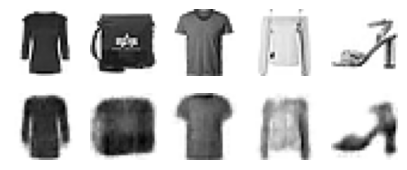

In [12]:
plot_reconstructions(conv_autoencoder)


## Denoising Autoencoders

In [13]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(30,activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])
dropout_autoencoder = tf.keras.Sequential([dropout_encoder,dropout_decoder])
dropout_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())
history = dropout_autoencoder.fit(X_train,X_train,
                                  epochs=10,
                                  validation_data=(X_valid,X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0390 - val_loss: 0.0219
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0229 - val_loss: 0.0203
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0217 - val_loss: 0.0197
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0209 - val_loss: 0.0189
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0202 - val_loss: 0.0187
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0199 - val_loss: 0.0180
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0189 - val_loss: 0.0173


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


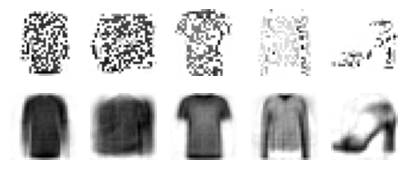

In [14]:
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_autoencoder,dropout(X_valid,training=True))
plt.show()


## Sparse Autoencoder

In [15]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(300,activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])
sparse_l1_autoencoder = tf.keras.Sequential([sparse_l1_encoder,sparse_l1_decoder])
sparse_l1_autoencoder.compile(loss="mse",optimizer="nadam")
history = sparse_l1_autoencoder.fit(X_train,X_train,
                                  epochs=10,
                                  validation_data=(X_valid,X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0818 - val_loss: 0.0311
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0297 - val_loss: 0.0273
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0266 - val_loss: 0.0252
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0247 - val_loss: 0.0239
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0234 - val_loss: 0.0225
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0222 - val_loss: 0.0217
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0215 - val_loss: 0.0210
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0209 - val_loss: 0.0206
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0203 - val_loss: 0.0202
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0200 - val_loss: 0.0199


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


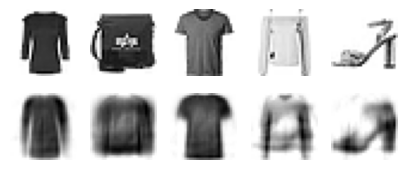

In [16]:
plot_reconstructions(sparse_l1_autoencoder)
plt.show()

In [17]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self,weight,target):
    self.weight = weight
    self.target = target
  def __call__(self,inputs):
    mean_activities = tf.reduce_mean(inputs,axis=0)
    return self.weight*(
        kl_divergence(self.target,mean_activities)+
        kl_divergence(1. - self.target,1. - mean_activities))

In [18]:
kld_reg = KLDivergenceRegularizer(weight=5e-3,target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(300,activation="sigmoid",
                          activity_regularizer=kld_reg
                          )
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])
sparse_kl_autoencoder = tf.keras.Sequential([sparse_kl_encoder,sparse_kl_decoder])
sparse_kl_autoencoder.compile(loss="mse",optimizer="nadam")
history = sparse_kl_autoencoder.fit(X_train,X_train,
                                    epochs=10,
                                    validation_data=(X_valid,X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0698 - val_loss: 0.0219
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0204 - val_loss: 0.0178
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0106 - val_loss: 0.0103
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0100 - val_loss: 0.0103


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


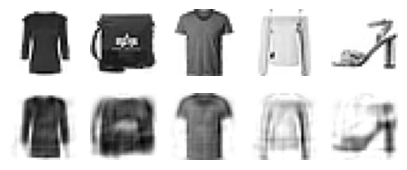

In [19]:
plot_reconstructions(sparse_kl_autoencoder)

## Variational Autoencoders

In [80]:
class Sampling(tf.keras.layers.Layer):
  def call(self,inputs):
    mean , log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var/2) + mean

In [81]:
class KLLoss(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        kl = -0.5 * tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=-1)
        self.add_loss(tf.reduce_mean(kl) / 784.)  # scale like MSE
        return mean

In [82]:
coding_size = 10
input = tf.keras.layers.Input(shape = [28,28])
Z = tf.keras.layers.Flatten()(input)
Z = tf.keras.layers.Dense(150,activation="relu")(Z)
Z = tf.keras.layers.Dense(100,activation="relu")(Z)
coding_mean = tf.keras.layers.Dense(coding_size)(Z)  # μ
coding_log_var = tf.keras.layers.Dense(coding_size)(Z) # γ
KLOutput = KLLoss()([coding_mean,coding_log_var])
coding = Sampling()([coding_mean,coding_log_var])
variational_encoder = tf.keras.Model(inputs=[input],outputs=[coding_mean,coding_log_var,
                                                               coding])


In [83]:
decoder_inputs = tf.keras.layers.Input(shape=[coding_size])
x = tf.keras.layers.Dense(100,activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150,activation="relu")(x)
x = tf.keras.layers.Dense(28*28)(x)
output = tf.keras.layers.Reshape([28,28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs],outputs=[output])

In [84]:
_,_,codings = variational_encoder(input)
reconstruction = variational_decoder(codings)
variational_autoencoder = tf.keras.Model(inputs=[input],outputs=[reconstruction])

In [85]:
variational_autoencoder.compile(loss="mse",optimizer=tf.keras.optimizers.Nadam())
history = variational_autoencoder.fit(X_train,X_train,
                                      epochs=30,
                                      validation_data=(X_valid,X_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0358 - val_loss: 0.0188
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 9/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0147 - val_loss: 0.0150
Epoch 10/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0145 - val_loss: 0.0148
Epoch 11/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0145 - val_loss: 0.0147
Epoch 12/30
1719/1719 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


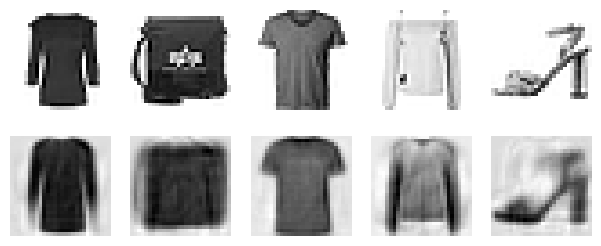

In [86]:
def plot_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])

    # Handle if model returns a list
    if isinstance(reconstructions, list):
        reconstructions = reconstructions[0]  # Take first item

    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for i in range(n_images):
        plt.subplot(2, n_images, 1 + i)
        plt.imshow(images[i], cmap="binary")
        plt.axis("off")

        plt.subplot(2, n_images, 1 + n_images + i)
        plt.imshow(reconstructions[i], cmap="binary")
        plt.axis("off")

plot_reconstructions(variational_autoencoder, X_valid)
plt.show()

## Generate Images


In [107]:
codings = tf.random.normal(shape=[3 * 7, coding_size])
images = variational_decoder(codings).numpy()

In [108]:
images.shape

(21, 28, 28)

In [109]:
def plot_multiple_images(images,n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1]==1:
    images = images.squeeze(axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index ,image in enumerate(images):
    plt.subplot(n_rows,n_cols,index+1)
    plt.imshow(image,cmap="binary")
    plt.axis("off")

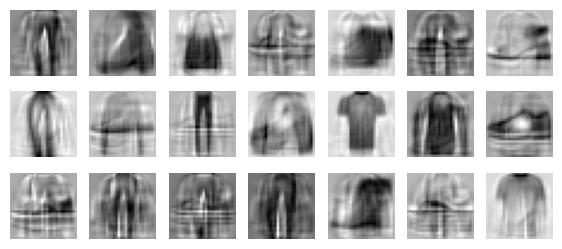

In [110]:
plot_multiple_images(images,7)

In [149]:
codings = np.zeros([7,coding_size])
codings

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [163]:
codings[:,5] = np.linspace(-0.8, 0.8, 7)
codings

array([[ 0.        ,  0.        , -0.8       , -0.8       ,  0.        ,
        -0.8       , -0.8       ,  0.        , -0.8       ,  0.        ],
       [ 0.        ,  0.        , -0.53333333, -0.53333333,  0.        ,
        -0.53333333, -0.53333333,  0.        , -0.53333333,  0.        ],
       [ 0.        ,  0.        , -0.26666667, -0.26666667,  0.        ,
        -0.26666667, -0.26666667,  0.        , -0.26666667,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.26666667,  0.26666667,  0.        ,
         0.26666667,  0.26666667,  0.        ,  0.26666667,  0.        ],
       [ 0.        ,  0.        ,  0.53333333,  0.53333333,  0.        ,
         0.53333333,  0.53333333,  0.        ,  0.53333333,  0.        ],
       [ 0.        ,  0.        ,  0.8       ,  0.8       ,  0.        ,
         0.8       ,  0.8       ,  0.        

In [164]:
images = variational_decoder(codings).numpy()


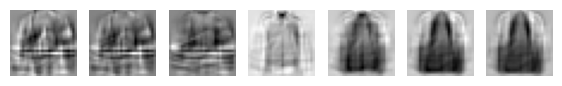

In [165]:
plot_multiple_images(images)